In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objects as go
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import ast

from nltk.corpus import stopwords
dutch_stopwords = stopwords.words('dutch')

import re

c:\Users\Y.vanMegen\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_bertopic_model(n_topics, min_topic_size=10, ngram_range=(1, 1)):
    embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
    hdbscan_model = HDBSCAN(min_cluster_size=min_topic_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    vectorizer_model = CountVectorizer(stop_words=dutch_stopwords, ngram_range=ngram_range)

    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        nr_topics=n_topics,
        verbose=True
    )
    return topic_model

In [3]:

def calculate_coherence_score(texts, topic_words, ngram_range=(1, 1)):
    # Zorg dat tokens correct zijn
    texts = [ast.literal_eval(doc) if isinstance(doc, str) else doc for doc in texts]

    # Maak n-gram strings van tokens
    joined_texts = [" ".join(doc) for doc in texts]
    vectorizer = CountVectorizer(ngram_range=ngram_range).fit(joined_texts)

    # Maak per document lijst met gegenereerde n-grams
    ngram_texts = [list(ngrams) for ngrams in vectorizer.inverse_transform(vectorizer.transform(joined_texts))]

    # Maak Gensim dictionary en coherence model
    dictionary = Dictionary(ngram_texts)
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=ngram_texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return coherence_model.get_coherence()

In [4]:
def analyze_topics_with_sentiment(texts, embeddings, data, n_topics_list=[20], n_words_list=[5], ngram_range=(1, 2), calculate_coherence=True):
    results = {}
    summary_data = []
    all_doc_tags = {}
    data_df = data.copy()

    for n_topics in n_topics_list:
        for n_words in n_words_list:
            print(f"\nAnalyzing with {n_topics} topics, {n_words} words, ngram_range={ngram_range}")

            topic_model = create_bertopic_model(n_topics, ngram_range=ngram_range)
            topics, probs = topic_model.fit_transform(texts, embeddings)
            topic_info = topic_model.get_topic_info()

            # Verwerk keywords per topic
            topic_words = {}
            for topic in set(topics):
                if topic != -1:
                    words = topic_model.get_topic(topic)[:n_words]
                    topic_words[topic] = [word for word, _ in words]

            # Coherence berekenen
            topic_word_list = list(topic_words.values())
            if calculate_coherence == True:
                # coherence = calculate_coherence_score(data['tokens'].tolist(), topic_word_list)
                print("Calculating coherence score...")
                coherence = calculate_coherence_score(data['tokens'].tolist(), topic_word_list, ngram_range=ngram_range)
                print(f"Coherence Score: {coherence:.4f}")
            else:
                print("Skipping coherence calculation...")
                coherence = None
                print("Coherence Score (C_v):", coherence)
                       

            # Per document: top topics (≥ threshold)
            doc_tags = []
            threshold = 0.1
            for i, topic in enumerate(topics):
                if probs is None or isinstance(probs[i], float):
                    # fallback als probs None of 1D zijn
                    tags = [f"Topic {topic}"]
                else:
                    tags = [f"Topic {j}" for j, p in enumerate(probs[i]) if p > threshold]
                doc_tags.append(tags if tags else ["Unclear"])

            # Per document: keywords van toegekende topic (voor extra inzicht)
            topic_keywords_per_doc = [
                topic_words.get(t, []) if t in topic_words else [] for t in topics
            ]

            # Update dataframe
            data_df[f'topic_{n_topics}_{n_words}'] = topics
            data_df[f'tags_{n_topics}_{n_words}'] = doc_tags
            data_df[f'keywords_{n_topics}_{n_words}'] = topic_keywords_per_doc


            results[(n_topics, n_words, ngram_range)] = {
                'model': topic_model,
                'topics': topics,
                'probs': probs,
                'topic_words': topic_words,
                'coherence': coherence,
                'topic_info': topic_info
            }


            summary_data.append({
                'n_topics': n_topics,
                'n_words': n_words,
                'ngram_range': str(ngram_range),
                'coherence': coherence
            })


    grid_summary = pd.DataFrame(summary_data).sort_values(by='coherence', ascending=False)
    return results, grid_summary, topic_model, data_df


In [5]:
def print_results_summary(results, texts, save_to_file=True, filename=None):
    import datetime

    output_lines = []

    # for (n_topics, n_words), result in results.items():
    for key, result in results.items():
        print('key:', key)
        if isinstance(key, tuple) and len(key) == 3:
            n_topics, n_words, ngram_range = key
        else:
            n_topics, n_words = key
            ngram_range = "(1, 1)"

        # output_lines.append(f"\n=== Results for {n_topics} topics with {n_words} words ===")
        output_lines.append(f"\n=== Results for {n_topics} topics with {n_words} words (ngram_range={ngram_range}) ===")
        # output_lines.append(f"Coherence Score: {result['coherence']:.4f}")
        coherence = result.get('coherence')
        if coherence is not None:
            output_lines.append(f"Coherence Score: {coherence:.4f}")
        else:
            output_lines.append("Coherence Score: Not available")

        
        output_lines.append("\nTopics and their key words:")
        topic_info = result['topic_info']
        for _, row in topic_info.iterrows():
            topic_num = row['Topic']
            if topic_num != -1:
                words = row['Representation']
                output_lines.append(f"Topic {topic_num}: {', '.join(words)}")

        topic_sizes = topic_info[topic_info['Topic'] != -1]['Count'].tolist()
        output_lines.append("\nTopic sizes: " + str(topic_sizes))
        output_lines.append("\n" + "="*50)

    full_output = "\n".join(output_lines)

    # Print to console
    print(full_output)

    # Optionally save to file
    if save_to_file:
        if not filename:
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"topic_results_summary_{timestamp}.txt"
        
        with open(filename, "w", encoding="utf-8") as f:
            f.write(full_output)
        print(f"\n📁 Summary saved to: {filename}")

In [6]:
def fix_character_tokens(char_list):
    text = ''.join(char_list)
    tokens = text.split()  # crude but often works
    return tokens

def flatten_nested_char_lists(nested_list):
    return [''.join(token) for token in nested_list if isinstance(token, list)]
    # return [token for token in nested_list if token != []]




In [7]:
import ast

# Load your data
data = pd.read_csv('a:/df_cleaned.csv')

# Parse the stringified lists into real Python lists
data['tokens'] = data['tokens'].apply(lambda x: ast.literal_eval(x))


remove_list = [
        # Units, measurements, filler symbols
        'mg', 'mmoll', 'mmolL', 'x', 'per', 'dag', 'min', 'uur', 'ml', 'eenhed',

        # Admin & structure
        'samenvatting', 'memo', 'beleid', 'conclusie', 'aanvullend', 'afgewerken', 
        'opdracht', 'opdrachten', 'rapportage', 'diversen', 'contact', 'afspraak', 
        'tijd', 'tijdsduur', 'datum', 'poli', 'recept', 'gefaxt', 'bellen', 
        'akkoord', 'nodig', 'bekende', 'bekend', 'memo', 'scorelijzen', 'naslag',

        # Identifying or privacy-sensitive terms
        'bsn', 'city', 'postcode', 'firstname', 'lastname', 'streetname', 'phonenumber', 'voicemail', 
        'mw', 'dhr', 'mevrouw', 'meneer', 'zoon', 'mevr', 'mvr', 'dhr'
        'inge', 'valkenburg', 'peter', 'miriam', 'debby', 'eliane',

        # Clinical history / often uninformative by itself
        'anamnese', 'anamnees', 'voorgeschiedenis', 'huisarts', 
        'hoofdbehandelaar',

        # Temporal or ambiguous
        'sinds', 'dagen', 'weken', 'maanden', 'week', 'avond', 'nacht', 'ochtend', 'middag', 
        'extra', 'stop', 'gehad', 'gezien', 'zien', 'dd', 
        'ivm', 'links', 'rechts', 'linker', 'dr', 'overige', 'algemeen', 'patiënt', 'patiënte',

        # Admin/communication
        'verzoek', 'mail', 'mailen', 'verstuuren', 'brief', 'uitinen', 'ak', 'bespreeklijst', 
        'wijzigingopmerking',
        'voicemail', 'telefonisch', 'mobiel', 'ingesproek', 'aanleiding', 'telefoon', 'email', 'bereiken', 'svp', 'contactpersoon'
        'terugbellen', 'gemaild', 'insproken', 'voicemail',

        # Unclear / possibly noise
        'eenhed', 'aangeeft', 'scorelijzen', 'inten', 'intn', 'vb', 'sub', 

        # extra         
        'regelen', 'opmerking', 'bespreeklijst', 'sehperiode', 'bedrijf', 
        'ivb', 'mtps', 'cp', 'pat', 'huisadres', 'gg', 
        'medewerker', 'medewerk', 'laboratorium', 'apotheek', 'maand', 'tc', 
        'wonen', 'gezondheidsinstelling', 'leven', 'varken', 'soms', 'jaar', 'mgdag', 'lateraal',
        'bespreking', 'wondfoto', 'cze',         
        
        'vrijdag', 'maandag', 'donderdag', 'woensdag', 'zaterdag', 'zondag',      
        'juli', 'augustus', 'september', 'oktober', 'november', 'december', 'januari', 'februari', 'maart', 'april', 'mei', 'jun',
        
        
        # 'voltooid', 'verdenking', 'waarvoor', 'reden', 'waarschijnlijk', 'mogelijk', 'stuk', 'basisdosering', 'probleem', 'probleemlijst', 'actie',
        # 'nee', 'ja',  'arts',  'radiologie', 'internist', 'evaluatie', 'intake', 'controle',


        ]

data['tokens'] = data['tokens'].apply(lambda tokens: [word for word in tokens if word not in remove_list])

# Remove double words that are next to each other
for i in range(len(data)):
    tokens = data['tokens'].loc[i]
    # print("tokens list length:", len(tokens))
    new_tokens = []
    for j in range(len(tokens) - 1):
        if tokens[j] == tokens[j + 1]:
            print("Duplicate token found:", tokens[j], 'and', tokens[j + 1])
        else:
            new_tokens.append(tokens[j])
    # Append the last token since it won't be checked in the loop
    if tokens:
        new_tokens.append(tokens[-1])
    data['tokens'].loc[i] = new_tokens
    # print("New tokens list length:", len(new_tokens))

# Remove empty documents
data = data[data['tokens'].apply(len) > 0]

# Convert token lists to strings for BERTopic
data['text'] = data['tokens'].apply(lambda tokens: ' '.join(tokens))
texts = data['text'].tolist()

# Debug prints
print("First 3 token lists:", data['tokens'].head(3).tolist())
print("First 3 texts:", data['text'].head(3).tolist())
print("Total documents after filtering:", len(texts))


Duplicate token found: bloedgroep and bloedgroep
Duplicate token found: coloscopie and coloscopie
Duplicate token found: acenocoumarol and acenocoumarol
Duplicate token found: Fentanyl and Fentanyl
Duplicate token found: bloed and bloed
Duplicate token found: coloscopie and coloscopie
Duplicate token found: visite and visite
Duplicate token found: visite and visite
Duplicate token found: duodenum and duodenum
Duplicate token found: seh and seh
Duplicate token found: visite and visite
Duplicate token found: visite and visite
Duplicate token found: pijnscore and pijnscore
Duplicate token found: gibloeding and gibloeding
Duplicate token found: triage and triage
Duplicate token found: intern and intern
Duplicate token found: collumcaar and collumcaar
Duplicate token found: pijnscore and pijnscore
Duplicate token found: triage and triage
Duplicate token found: def and def
Duplicate token found: vocht and vocht
Duplicate token found: collumcaar and collumcaar
Duplicate token found: pijnscore

In [8]:
# Load embeddings

### model7 is from before removing duplicates
### model8 is with removal of duplicates based on words that are next to each other

embeddings = np.load('embeddings_model8.npy')
# embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# embeddings = embedding_model.encode(texts, show_progress_bar=True)
# np.save('embeddings_model8.npy', embeddings)

# print("embeddings:", embeddings)
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (9493, 384)


In [9]:
results_2to3, grid_summary_2to3, topic_model_2to3, data_df_2to3 = analyze_topics_with_sentiment(texts, embeddings, data, n_topics_list=[20], n_words_list=[5], ngram_range=(2, 3))



Analyzing with 20 topics, 5 words, ngram_range=(2, 3)


2025-04-23 16:37:13,029 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-23 16:37:52,027 - BERTopic - Dimensionality - Completed ✓
2025-04-23 16:37:52,028 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-23 16:37:52,408 - BERTopic - Cluster - Completed ✓
2025-04-23 16:37:52,409 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-23 16:37:58,319 - BERTopic - Representation - Completed ✓
2025-04-23 16:37:58,334 - BERTopic - Topic reduction - Reducing number of topics
2025-04-23 16:37:58,400 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-23 16:38:04,347 - BERTopic - Representation - Completed ✓
2025-04-23 16:38:04,367 - BERTopic - Topic reduction - Reduced number of topics from 249 to 20


Calculating coherence score...
Coherence Score: 0.8411


In [11]:
topic_model_2to3  # BERTopic model
results_2to3[(20, 5, (2, 3))]['probs']  # document-topic probabilities
data_df_2to3  # includes topic assignments and tags


,pseudo_id,verslagen_report_tags,verslagen_report_content,verslagen_report_start_date,date,alltext,tokens,text,topic_20_5,tags_20_5,keywords_20_5
0,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,Klinische Brief,"Dhr. A.J. Dingemans, huisarts\r\n[STREETNAME] ...",2020-11-26 15:06:00,2020-11-26 15:06:00,dhr aj dingemans huisarts streetnaam city datu...,"[aj, dingemans, streetnaam, Kenmerk, patientid...",aj dingemans streetnaam Kenmerk patientid betr...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
1,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,"Consult, Kliniek: vervolgconsult",Samenvatting: \nRectaal bloedverlies obv diver...,2020-11-26 09:53:00,2020-11-26 09:53:00,samenvatting rectaal bloedverlie obvn divertik...,"[rectaal, bloedverlie, obvn, divertikelbloedin...",rectaal bloedverlie obvn divertikelbloeding ac...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
2,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,Poliklinische Brief,COLOSCOPIE\r\n\r\nBetreft\r\nMw. [INITIALS] [L...,2020-11-25 14:13:00,2020-11-25 14:13:00,coloscopie betreffen mw initials lastname adre...,"[coloscopie, betreffen, initials, adresgegeven...",coloscopie betreffen initials adresgegevens st...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
3,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,Poliklinische Brief,GASTROSCOPIE\r\n\r\nBetreft\r\nMw. [INITIALS] ...,2020-11-25 13:48:00,2020-11-25 13:48:00,gastroscopie betreffen mw initials lastname ad...,"[gastroscopie, betreffen, initials, adresgegev...",gastroscopie betreffen initials adresgegevens ...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
4,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,"Consult, Kliniek: vervolgconsult",Samenvatting: \nRectaal bloedverlies ; eenmali...,2020-11-25 08:47:00,2020-11-25 08:47:00,samenvatting rectaal bloedverlie eenmalig hd h...,"[rectaal, bloedverlie, eenmalig, hd, hbstabiel...",rectaal bloedverlie eenmalig hd hbstabiel inr ...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
...,...,...,...,...,...,...,...,...,...,...,...
9572,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,Consult,Samenvatting: \n1e consult\r\n-Type 1e consult...,2015-03-20 08:13:00,2015-03-20 08:13:00,samenvatting consult type consult uitbreiden a...,"[consult, type, consult, uitbreiden, consult, ...",consult type consult uitbreiden consult reden ...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
9573,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,"Consult, Kliniek: vervolgconsult",Samenvatting: \nDecursus\r\n-Type decursus: De...,2015-01-14 15:39:00,2015-01-14 15:39:00,samenvatting decursus type decursus decursus s...,"[decursus, type, decursus, Rvo, nstemi, uwi, r...",decursus type decursus Rvo nstemi uwi rvc prom...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
9574,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,"Consult, SEH",Samenvatting: \nVerpleegkundige verslaglegging...,2014-12-21 09:31:00,2014-12-21 09:31:00,samenvatting verpleegkundig verslaglegging ver...,"[verpleegkundig, verslaglegging, verantwoordel...",verpleegkundig verslaglegging verantwoordelijk...,-1,[Topic -1],[]
9575,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,"Consult, SEH",Samenvatting: \nMedisch Dossier\r\n[ Vk Sputov...,2010-11-10 21:03:00,2010-11-10 21:03:00,samenvatting medisch dossier vk sputovamo leef...,"[medisch, dossier, vk, sputovamo, leeftijd, re...",medisch dossier vk sputovamo leeftijd registra...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."


In [15]:
def generate_event_labels(topic_words_dict, label_style="title"):
    label_dict = {}
    for topic_id, words in topic_words_dict.items():
        if not words: continue
        label = " / ".join(words[:3])  # pick top 3 n-grams
        if label_style == "title":
            label = label.replace("_", " ").title()
        label_dict[topic_id] = label
    return label_dict

# Apply
event_labels = generate_event_labels(results_2to3[(20, 5, (2, 3))]['topic_words'])
event_labels

{0: 'Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk',
 1: 'Diabete Mellitus / Mellitus Type / Diabete Mellitus Type',
 2: 'Uitvoeren Controle / Podo Decursus / Decursus Podo',
 3: 'Diabete Lunch / Diabete Lunch Slapen / Lunch Slapen',
 4: 'Overig Actie / Verz Transferrin / Hb Ht',
 5: 'Int Knoppen / Chronisch Recidiveren Depressie / Recidiveren Depressie',
 6: 'Beloop Verpleegkundig / Onderzoek Bloed Prikken / Bloed Prikken Controle',
 7: 'Aantal Controle / Controle Aantal / Aantal Controle Aantal',
 8: 'Vocht Toediening / Toediening Soort Infuus / Toediening Soort',
 9: 'Eosinofiel Enteritis / Alopecia Totalis / Atopisch Constitutie',
 10: 'Decursus Podo Decursus / Decursus Podo / Podo Decursus',
 11: 'Videocapsule Bloed / Gastroscopie Focus Videocapsule / Focus Videocapsule',
 12: 'Trauma Radiologie Seh / Bespreeklijst Trauma / Radiologie Seh',
 13: 'Rontg Echo / Rontg Echo Toelichting / Echo Toelichting',
 14: 'Sepsis Vpk Bestaan / Vpk Bestaan / Vpk Bestaan Basis',
 15: 'Sepsis Arts 

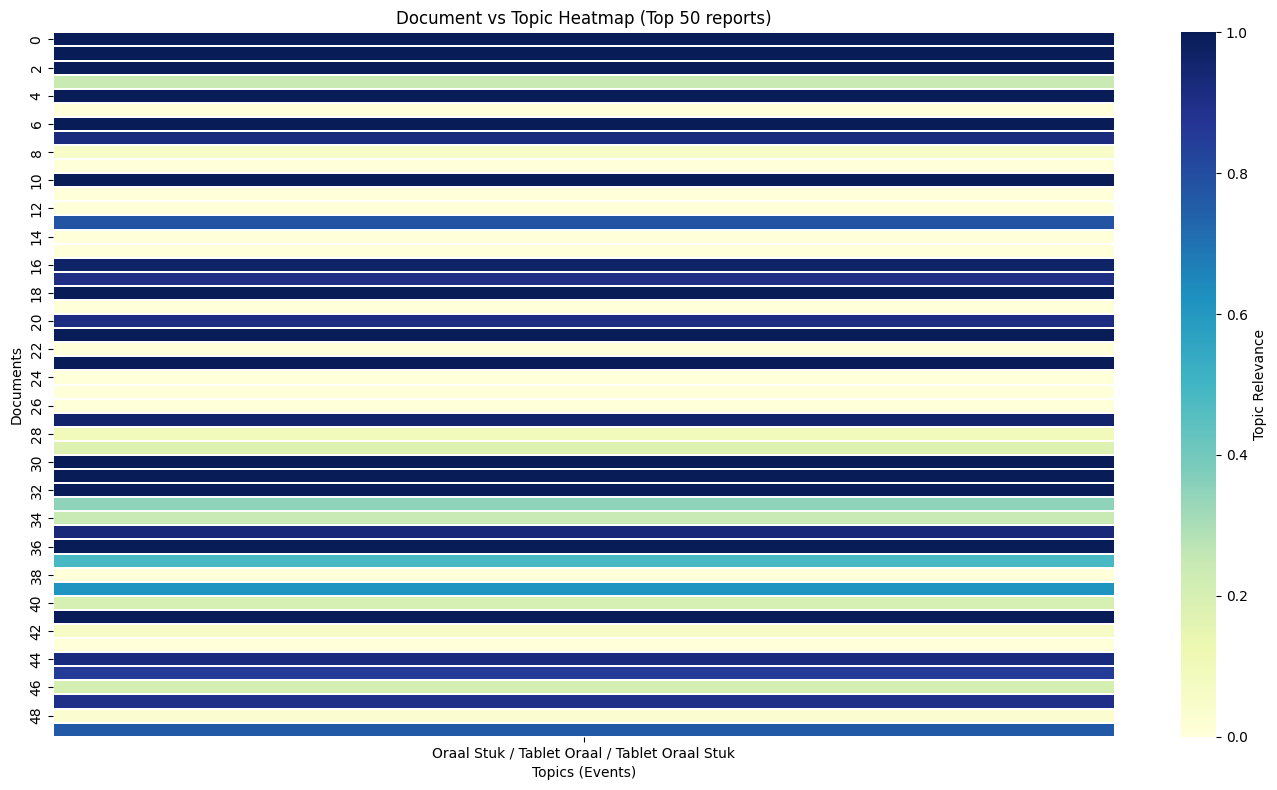

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Extract probabilities and topic labels
probs = results_2to3[(20, 5, (2, 3))]['probs']
topics = results_2to3[(20, 5, (2, 3))]['topics']
labels = generate_event_labels(results_2to3[(20, 5, (2, 3))]['topic_words'])

# Build a DataFrame (optional: filter to a subset of docs for legibility)
df_probs = pd.DataFrame(probs).iloc[:50]  # first 50 docs
df_probs.columns = [labels.get(i, f"Topic {i}") for i in df_probs.columns]

# Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(df_probs, cmap="YlGnBu", cbar_kws={'label': 'Topic Relevance'}, linewidths=0.1)
plt.title("Document vs Topic Heatmap (Top 50 reports)")
plt.xlabel("Topics (Events)")
plt.ylabel("Documents")
plt.tight_layout()
plt.show()


In [ ]:
# pip install seaborn

In [21]:
summary = data_df_2to3[['pseudo_id', f'topic_20_5', f'tags_20_5', f'keywords_20_5']]
summary['event_label'] = summary[f'topic_20_5'].map(event_labels)
summary


,pseudo_id,topic_20_5,tags_20_5,keywords_20_5,event_label
0,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ...",Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk
1,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ...",Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk
2,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ...",Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk
3,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ...",Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk
4,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ...",Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk
...,...,...,...,...,...
9572,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ...",Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk
9573,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ...",Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk
9574,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,-1,[Topic -1],[],NaN
9575,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ...",Oraal Stuk / Tablet Oraal / Tablet Oraal Stuk


In [25]:
results_2to3[(20, 5, (2, 3))]['probs']

array([1., 1., 1., ..., 0., 1., 0.])

In [26]:
data_df_2to3

,pseudo_id,verslagen_report_tags,verslagen_report_content,verslagen_report_start_date,date,alltext,tokens,text,topic_20_5,tags_20_5,keywords_20_5
0,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,Klinische Brief,"Dhr. A.J. Dingemans, huisarts\r\n[STREETNAME] ...",2020-11-26 15:06:00,2020-11-26 15:06:00,dhr aj dingemans huisarts streetnaam city datu...,"[aj, dingemans, streetnaam, Kenmerk, patientid...",aj dingemans streetnaam Kenmerk patientid betr...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
1,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,"Consult, Kliniek: vervolgconsult",Samenvatting: \nRectaal bloedverlies obv diver...,2020-11-26 09:53:00,2020-11-26 09:53:00,samenvatting rectaal bloedverlie obvn divertik...,"[rectaal, bloedverlie, obvn, divertikelbloedin...",rectaal bloedverlie obvn divertikelbloeding ac...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
2,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,Poliklinische Brief,COLOSCOPIE\r\n\r\nBetreft\r\nMw. [INITIALS] [L...,2020-11-25 14:13:00,2020-11-25 14:13:00,coloscopie betreffen mw initials lastname adre...,"[coloscopie, betreffen, initials, adresgegeven...",coloscopie betreffen initials adresgegevens st...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
3,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,Poliklinische Brief,GASTROSCOPIE\r\n\r\nBetreft\r\nMw. [INITIALS] ...,2020-11-25 13:48:00,2020-11-25 13:48:00,gastroscopie betreffen mw initials lastname ad...,"[gastroscopie, betreffen, initials, adresgegev...",gastroscopie betreffen initials adresgegevens ...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
4,046D1FFEBDD40E1665D0ABA6DD8FC9F8BC4351C6,"Consult, Kliniek: vervolgconsult",Samenvatting: \nRectaal bloedverlies ; eenmali...,2020-11-25 08:47:00,2020-11-25 08:47:00,samenvatting rectaal bloedverlie eenmalig hd h...,"[rectaal, bloedverlie, eenmalig, hd, hbstabiel...",rectaal bloedverlie eenmalig hd hbstabiel inr ...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
...,...,...,...,...,...,...,...,...,...,...,...
9572,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,Consult,Samenvatting: \n1e consult\r\n-Type 1e consult...,2015-03-20 08:13:00,2015-03-20 08:13:00,samenvatting consult type consult uitbreiden a...,"[consult, type, consult, uitbreiden, consult, ...",consult type consult uitbreiden consult reden ...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
9573,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,"Consult, Kliniek: vervolgconsult",Samenvatting: \nDecursus\r\n-Type decursus: De...,2015-01-14 15:39:00,2015-01-14 15:39:00,samenvatting decursus type decursus decursus s...,"[decursus, type, decursus, Rvo, nstemi, uwi, r...",decursus type decursus Rvo nstemi uwi rvc prom...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
9574,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,"Consult, SEH",Samenvatting: \nVerpleegkundige verslaglegging...,2014-12-21 09:31:00,2014-12-21 09:31:00,samenvatting verpleegkundig verslaglegging ver...,"[verpleegkundig, verslaglegging, verantwoordel...",verpleegkundig verslaglegging verantwoordelijk...,-1,[Topic -1],[]
9575,FD8C682C1F4FDA1E5EC0B760D30875556419BD71,"Consult, SEH",Samenvatting: \nMedisch Dossier\r\n[ Vk Sputov...,2010-11-10 21:03:00,2010-11-10 21:03:00,samenvatting medisch dossier vk sputovamo leef...,"[medisch, dossier, vk, sputovamo, leeftijd, re...",medisch dossier vk sputovamo leeftijd registra...,0,[Topic 0],"[oraal stuk, tablet oraal, tablet oraal stuk, ..."
